In [227]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from pylab import rcParams

data = pd.read_csv('marketing-data.csv')

In [228]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,is_success
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [229]:
def balance_status(row):
    value = row['balance']
    if value < 0:
        return 'neg'
    else :
        return 'pos'
    
def feature_categorization(feature):
    feat = data[feature].unique()
    if feature == 'is_success':
        feat_dict = {feat[i]: i for i in range(0,len(feat))}
    else:
        feat_dict = {feat[i]: i+1 for i in range(0,len(feat))}
    data[feature+'_cat'] = data[feature].apply(lambda row: feat_dict[row])
    data.drop(feature, axis=1, inplace=True)

def featurization(data):
    features = ['job','marital','education','default','housing','loan','contact','month','poutcome','is_success','balance_status']
    
    data['balance_status'] = data.apply(balance_status, axis = 1)
    data.drop('day', axis=1, inplace=True)
    
    for i in features:
        feature_categorization(i)

featurization(data)

In [230]:
data.head()

,age,balance,duration,campaign,pdays,previous,job_cat,marital_cat,education_cat,default_cat,housing_cat,loan_cat,contact_cat,month_cat,poutcome_cat,is_success_cat,balance_status_cat
0,58,2143,261,1,-1,0,1,1,1,1,1,1,1,1,1,0,1
1,44,29,151,1,-1,0,2,2,2,1,1,1,1,1,1,0,1
2,33,2,76,1,-1,0,3,1,2,1,1,2,1,1,1,0,1
3,47,1506,92,1,-1,0,4,1,3,1,1,1,1,1,1,0,1
4,33,1,198,1,-1,0,5,2,3,1,2,1,1,1,1,0,1


In [231]:
def cat_to_ohe(feature):

    enc = OneHotEncoder()
    feature_reshape = data[feature].values.reshape(-1, 1)
    cat_feat = enc.fit_transform(feature_reshape).toarray()
    
    #-1 to avoid dummy variable trap
    featr = [feature+' '+str(i+1) for i in range(0,cat_feat.shape[1]-1)]
    for i in range(0,len(featr)):
        data[featr[i]] = cat_feat[:,i]


def category_ohe(data):
    features = ['job','marital','education','default','housing','loan','contact','month','poutcome','is_success','balance_status']
    
    prev = data['pdays'].values
    prev = [1 if i == -1 else 0 for i in prev]
    data['pdays'] = prev
    
    features.remove('is_success')
    features_cat = [i+'_cat' for i in features]
        
    for i in features_cat:
        cat_to_ohe(i)
        data.drop(i, axis=1, inplace=True)

category_ohe(data)

In [232]:
data.head()

,age,balance,duration,campaign,pdays,previous,is_success_cat,job_cat 1,job_cat 2,job_cat 3,...,month_cat 6,month_cat 7,month_cat 8,month_cat 9,month_cat 10,month_cat 11,poutcome_cat 1,poutcome_cat 2,poutcome_cat 3,balance_status_cat 1
0,58,2143,261,1,1,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,44,29,151,1,1,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,33,2,76,1,1,0,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,47,1506,92,1,1,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,33,1,198,1,1,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [233]:
#Standardization :
def scale_feature(feature,df):
    values = df[feature].values
    values = values.reshape((len(values), 1))
     # train the standardization
    scaler = StandardScaler()
    scaler = scaler.fit(values)
    standardized = scaler.transform(values)
    
    return np.array(standardized)

def standardization_train_test_split(data):
    features = ['age', 'balance','duration','campaign', 'previous']
    
    x_train, x_test, y_train, y_test = train_test_split(data, data['is_success_cat'], test_size=0.25, random_state=30)
    x_train.drop('is_success_cat', axis=1, inplace=True)
    x_test.drop('is_success_cat', axis=1, inplace=True)
    
    for i in features:
        x_train[i+'_scaled'] = scale_feature(i,x_train)
        x_test[i+'_scaled'] = scale_feature(i,x_test)
        
        x_train.drop(i, axis=1, inplace=True)
        x_test.drop(i, axis=1, inplace=True)
    
    
    
    new_features = list(x_train.columns)
    print "New features: \n{} \n\n Number of features : {}".format(new_features,len(new_features))
    
    return [x_train,x_test,y_train,y_test]
    
dataset = standardization_train_test_split(data)

x_train = dataset[0]
x_test = dataset[1]
y_train = dataset[2]
y_test = dataset[3]

/home/arunghontale/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/arunghontale/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/arunghontale/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/arunghontale/anaco

New features: 
['pdays', 'job_cat 1', 'job_cat 2', 'job_cat 3', 'job_cat 4', 'job_cat 5', 'job_cat 6', 'job_cat 7', 'job_cat 8', 'job_cat 9', 'job_cat 10', 'job_cat 11', 'marital_cat 1', 'marital_cat 2', 'education_cat 1', 'education_cat 2', 'education_cat 3', 'default_cat 1', 'housing_cat 1', 'loan_cat 1', 'contact_cat 1', 'contact_cat 2', 'month_cat 1', 'month_cat 2', 'month_cat 3', 'month_cat 4', 'month_cat 5', 'month_cat 6', 'month_cat 7', 'month_cat 8', 'month_cat 9', 'month_cat 10', 'month_cat 11', 'poutcome_cat 1', 'poutcome_cat 2', 'poutcome_cat 3', 'balance_status_cat 1', 'age_scaled', 'balance_scaled', 'duration_scaled', 'campaign_scaled', 'previous_scaled'] 

 Number of features : 42


In [234]:
x_train.head()

,pdays,job_cat 1,job_cat 2,job_cat 3,job_cat 4,job_cat 5,job_cat 6,job_cat 7,job_cat 8,job_cat 9,...,month_cat 11,poutcome_cat 1,poutcome_cat 2,poutcome_cat 3,balance_status_cat 1,age_scaled,balance_scaled,duration_scaled,campaign_scaled,previous_scaled
374,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.666370,-0.403247,-0.269263,-0.574652,-0.239110
40217,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.854466,0.647088,-0.075716,0.401060,-0.239110
28604,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,-0.932443,-0.276920,1.410723,-0.249415,-0.239110
42961,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.556252,-0.456317,-0.757000,0.401060,1.809958
13054,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,-1.214587,-0.290921,0.183637,-0.574652,-0.239110


In [235]:
# def tsne_embeddings(data):

#     n_sne = 7000

#     time_start = time.time()

#     tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
#     tsne_results = tsne.fit_transform(x_train.values)

#     print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)
    
#     df_tsne = pd.DataFrame()
#     x_tsne = tsne_results[:,0]
#     y_tsne = tsne_results[:,1]
#     label = y_train.values
#     colors = ["yellow", "green"]
#     groups = ("Term deposit bought","Term deposit not bought") 
#     # Plot
#     data = (x_tsne,y_tsne)
#     colors = [colors[i] for i in label]
    
#     plt.scatter(x_tsne, y_tsne , s=5, c=colors, alpha=0.9)

#     plt.title('tSNE embeddings differentiated by term deposit')
#     plt.legend(loc=2)
#     plt.savefig('tsne .png')
#     plt.show()
    
# tsne_embeddings(x_train)

In [236]:
def show_confusion_matrix(C,classifier,class_labels=['0','1']):
    #Draws confusion matrix with associated metrics.
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tp = C[0,0]; fp = C[0,1]; fn = C[1,0]; tn = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.savefig(classifier+'_Confusion_mat')
    plt.show()

In [237]:
#Modelling stage which prints precison , recall, ROC curve 
def model(x_train,y_train,x_test,y_test,clf,classifier):

    clf.fit(list(x_train.values),list(y_train.values))
    y_pred = clf.predict(list(x_test.values))
    conf_mat = confusion_matrix(list(y_test), list(y_pred))

    print "Confusion matrix:\n",conf_mat

    #print confusion matrix
    show_confusion_matrix(conf_mat,classifier,['Negative','Positive'])

    #Precision and recall
    tp = conf_mat[0,0]; fp = conf_mat[0,1]; fn = conf_mat[1,0]; tn = conf_mat[1,1];

    precision = 100*float(tp)/(tp+fp)
    recall = 100*float(tp)/(tp+fn)

    print "Precision :",precision
    print "Recall :",recall
    
    try:
        # Compute ROC curve and ROC area for each class
        probs = clf.predict_proba(list(x_test.values))
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(list(y_test), preds)
        roc_auc = auc(fpr, tpr)

        #Plot ROC
        plt.figure(figsize=(12, 12))
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.savefig(classifier+'_ROC')
        plt.show()

        
    except:
        print "ROC Unavailable"


In [238]:
def plot_coefficients(clf):

    clf.fit(list(x_train.values),list(y_train.values))
    y_pred = clf.predict(list(x_test.values))
    try:
        coef = clf.coef_.ravel()
        top_coefficients = np.argsort(coef)
        features = x_train.columns
    
        # create plot

        plt.figure(figsize=(15, 10))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
        plt.bar(np.arange(len(features)), coef[top_coefficients], color=colors)

        feature_names = np.array(features)

        plt.xticks(np.arange(1, 1+len(features)), features[top_coefficients], rotation=50, ha='right')
        plt.show()
    except:
        coef = clf.feature_importances_.ravel()
        top_coefficients = np.argsort(coef)
        features = x_train.columns
    
        # create plot

        plt.figure(figsize=(15, 10))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
        plt.bar(np.arange(len(features)), coef[top_coefficients], color=colors)

        feature_names = np.array(features)

        plt.xticks(np.arange(1, 1+len(features)), features[top_coefficients], rotation=50, ha='right')
        plt.show()

Logistic Regression
Confusion matrix:
[[8713 1311]
 [ 296  983]]


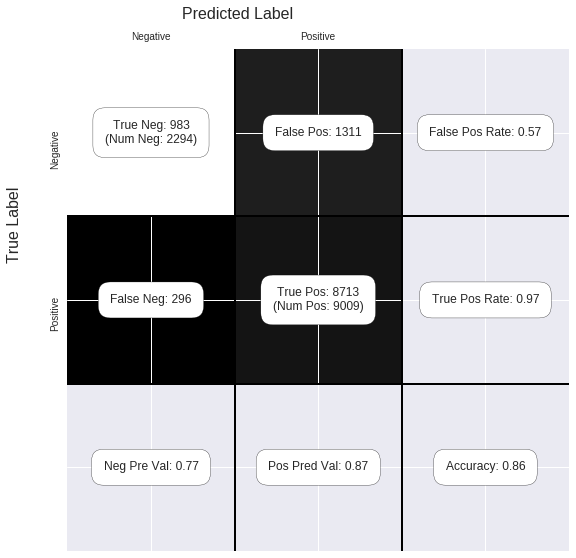

Precision : 86.9213886672
Recall : 96.7143967144


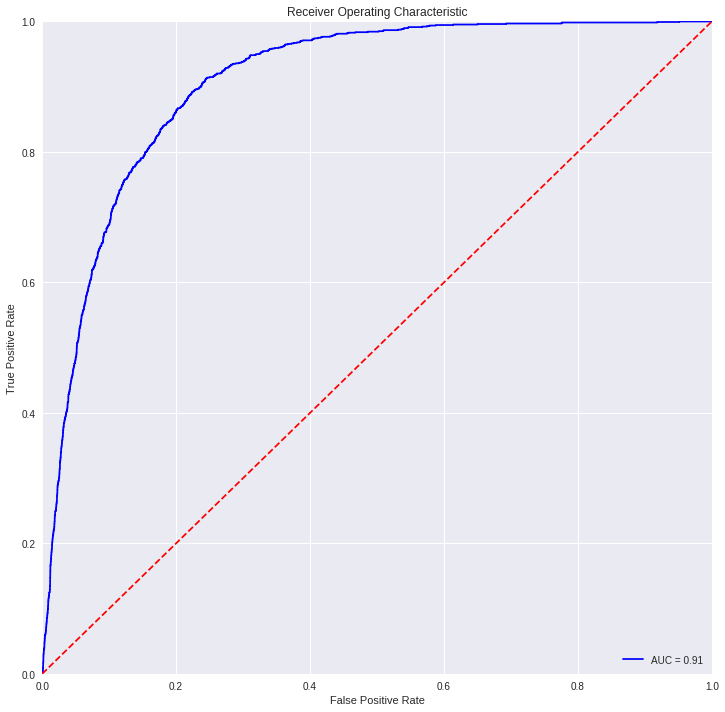

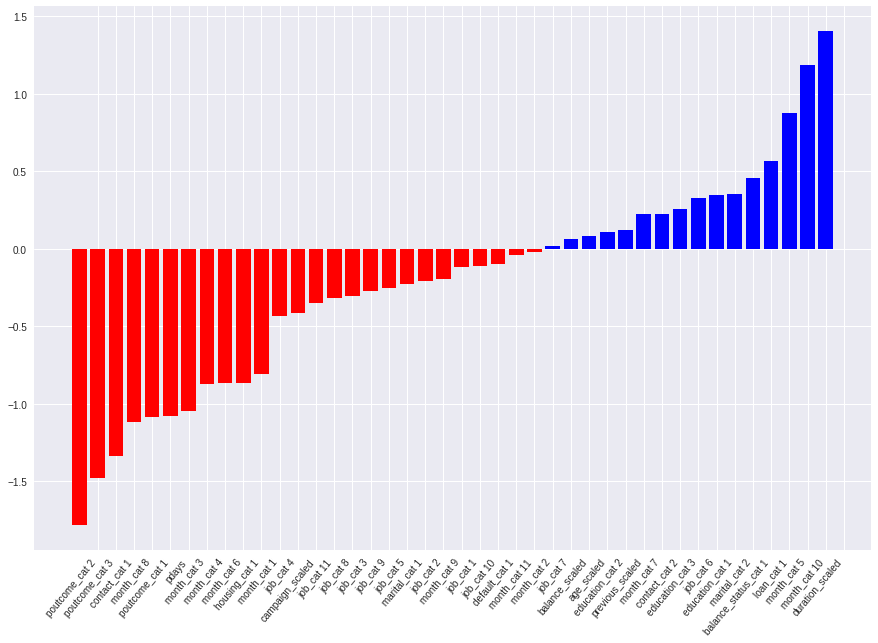



Linear SVM
Confusion matrix:
[[6698 3326]
 [  74 1205]]


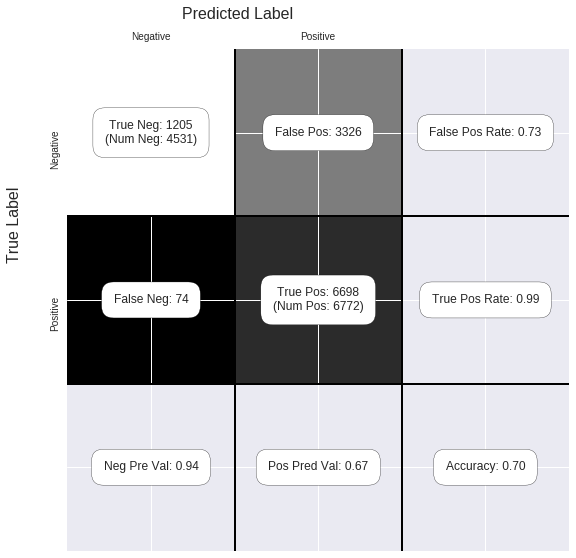

Precision : 66.8196328811
Recall : 98.9072652097
ROC Unavailable


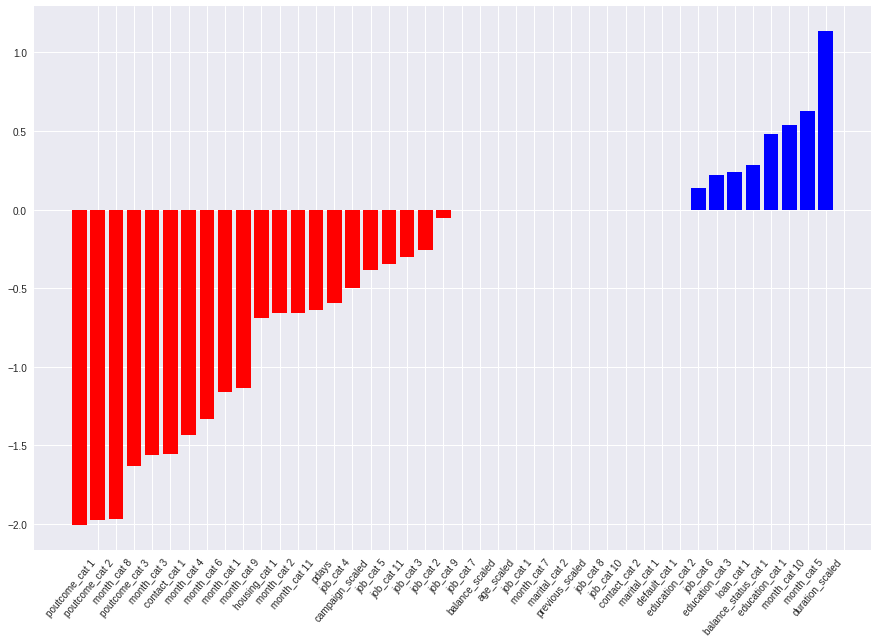



Random Forest Classifier
Confusion matrix:
[[9551  473]
 [ 688  591]]


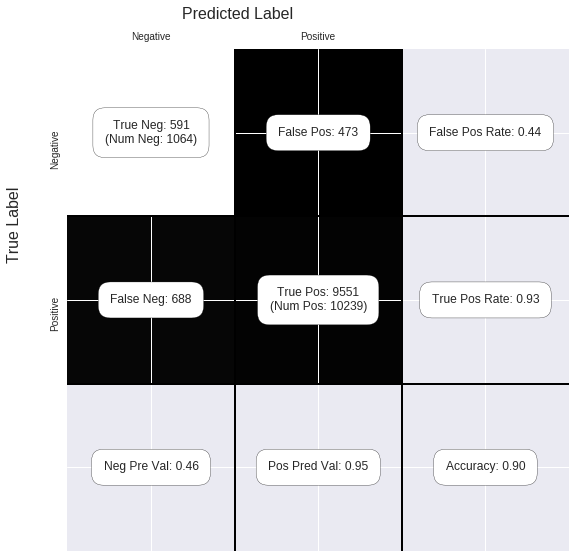

Precision : 95.2813248204
Recall : 93.280593808


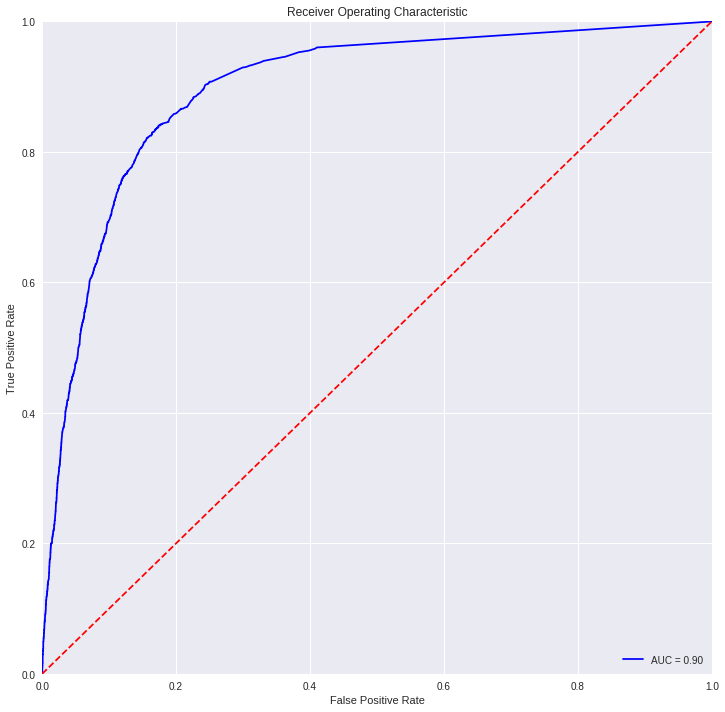

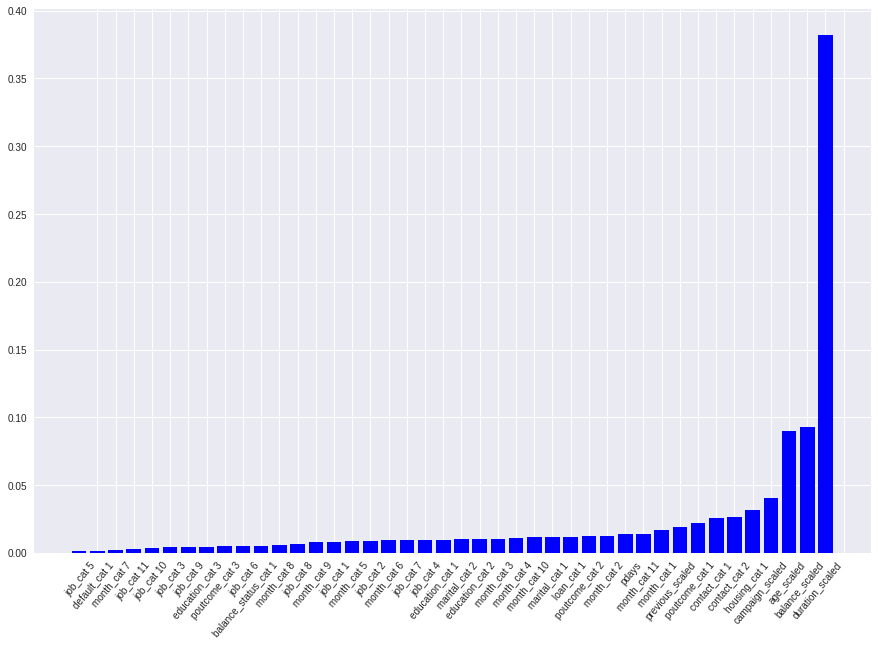

In [239]:
print "Logistic Regression"
#Logistic Regression
clf = SGDClassifier(loss = 'log',alpha = 0.001,penalty = 'l2',class_weight = 'balanced')
model(x_train,y_train,x_test,y_test,clf,'logistic')
plot_coefficients(clf)
print "\n"
print "Linear SVM"
#Linear SVM
clf = SGDClassifier(loss = 'hinge',alpha = 0.0003,penalty = 'l1',class_weight = 'balanced')
model(x_train,y_train,x_test,y_test,clf,'SVM')
plot_coefficients(clf)
print "\n"

print "Random Forest Classifier"
#Random Forest Ensemble
clf = RandomForestClassifier(n_estimators=12,class_weight = 'balanced',criterion = 'gini',\
                            min_samples_split=4) 
model(x_train,y_train,x_test,y_test,clf,'Random Forest')
plot_coefficients(clf)

/home/arunghontale/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/arunghontale/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Logistic Regression
Confusion matrix:
[[7360 2664]
 [ 432  847]]


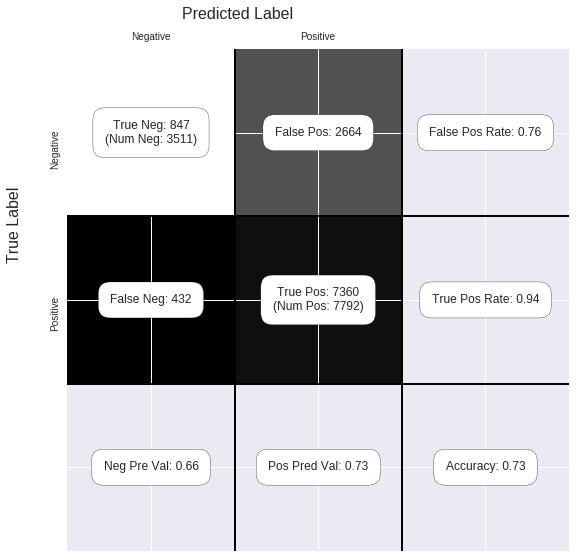

Precision : 73.423782921
Recall : 94.4558521561


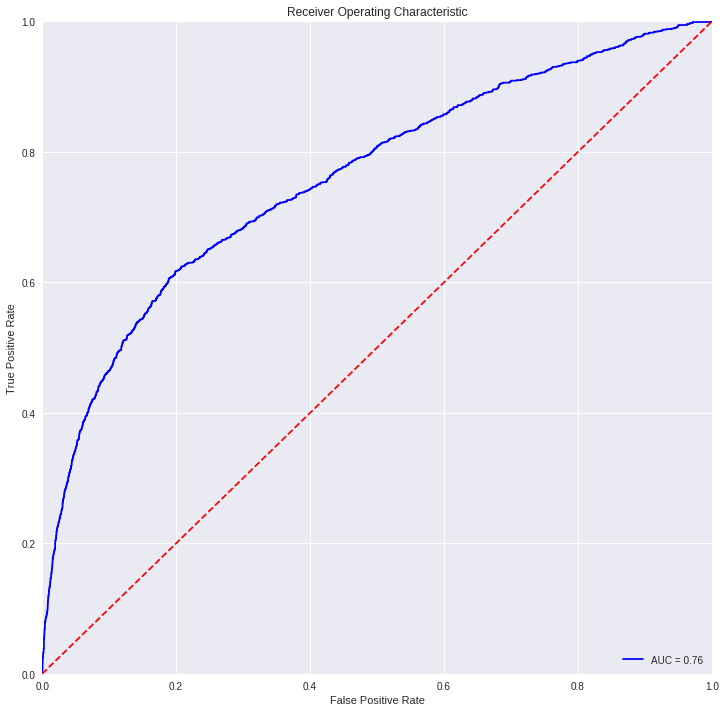

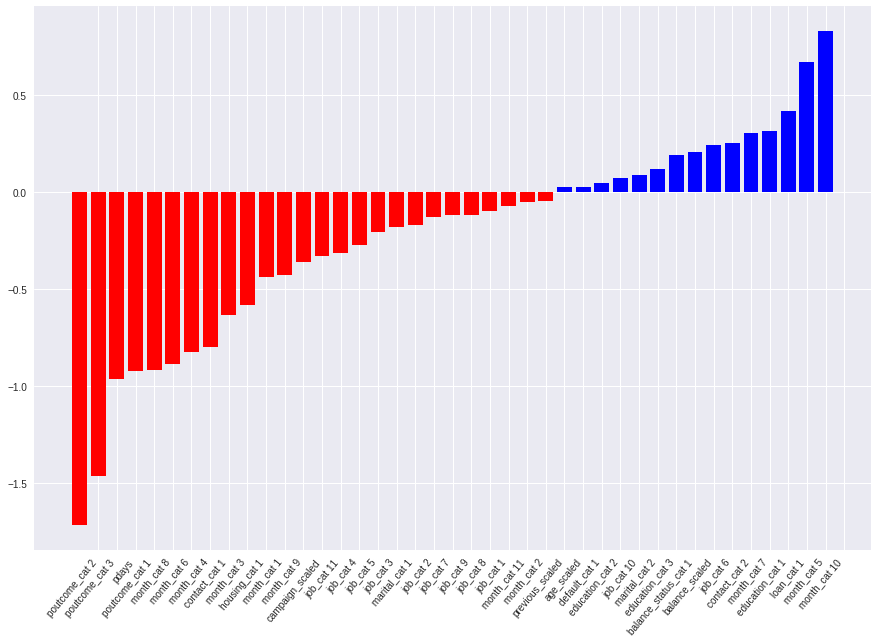



Linear SVM
Confusion matrix:
[[8681 1343]
 [ 652  627]]


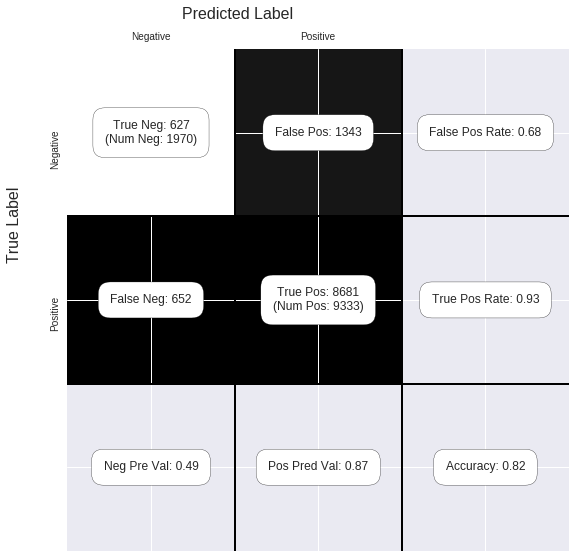

Precision : 86.6021548284
Recall : 93.0140362156
ROC Unavailable


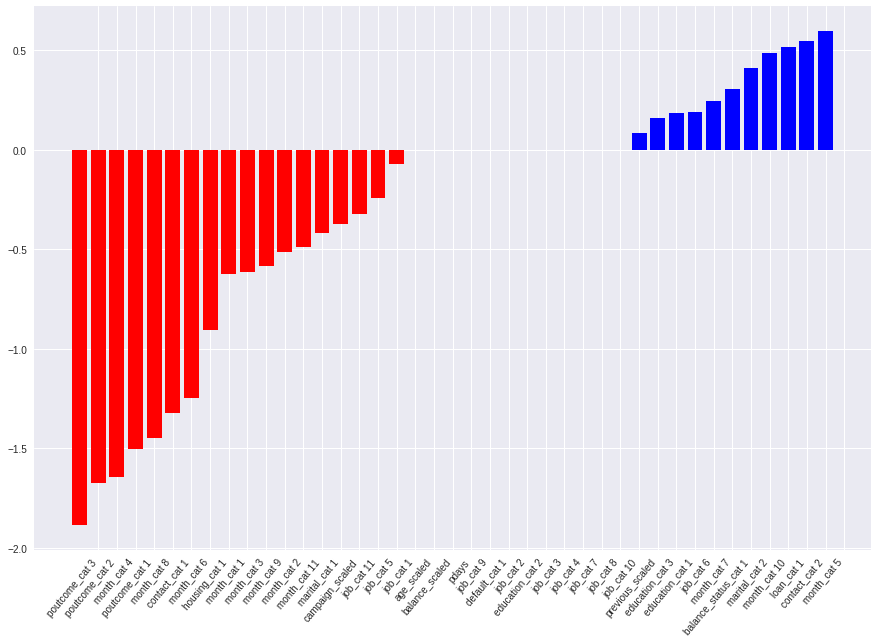



Random Forest Classifier
Confusion matrix:
[[9602  422]
 [ 922  357]]


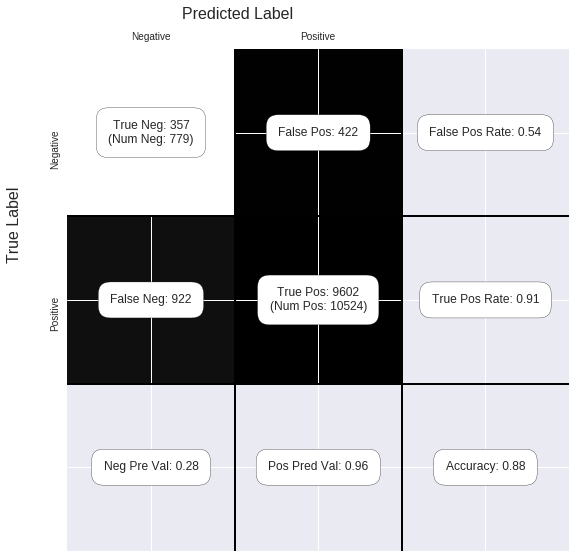

Precision : 95.790103751
Recall : 91.239072596


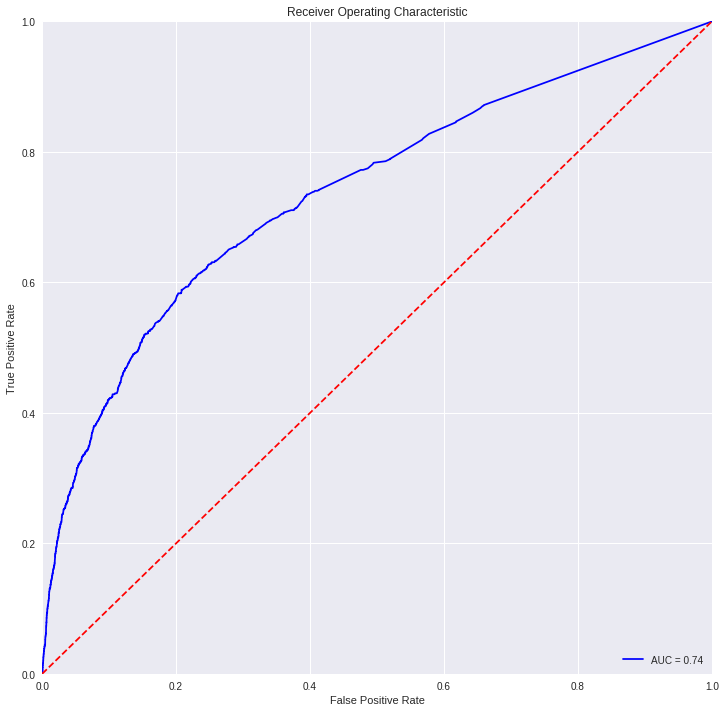

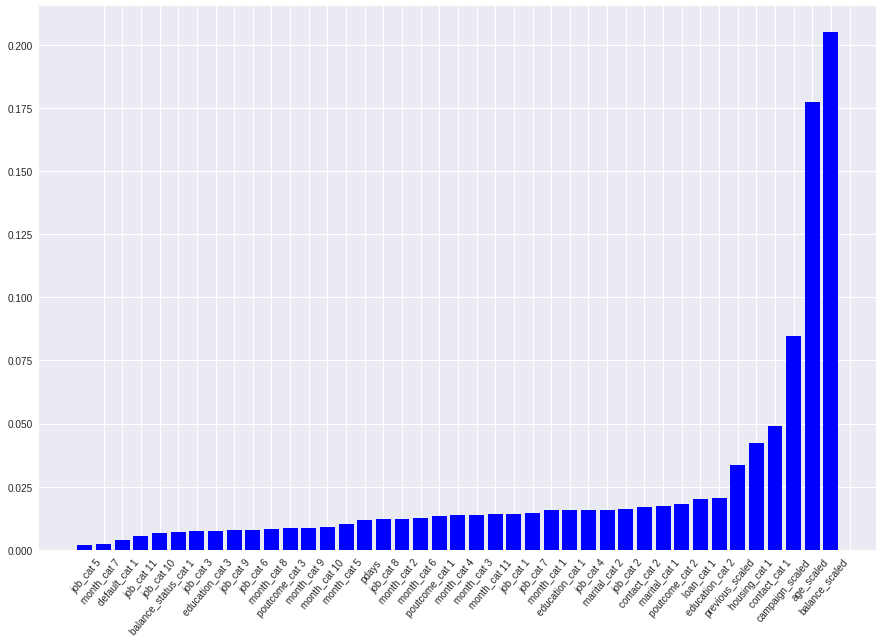

In [240]:
#Removing the duration feature

x_train.drop('duration_scaled',axis=1, inplace=True)
x_test.drop('duration_scaled',axis=1, inplace=True)

print "Logistic Regression"
#Logistic Regression
clf = SGDClassifier(loss = 'log',alpha = 0.001,penalty = 'l2',class_weight = 'balanced')
model(x_train,y_train,x_test,y_test,clf,'logistic')
plot_coefficients(clf)
print "\n"
print "Linear SVM"
#Linear SVM
clf = SGDClassifier(loss = 'hinge',alpha = 0.0003,penalty = 'l1',class_weight = 'balanced')
model(x_train,y_train,x_test,y_test,clf,'SVM')
plot_coefficients(clf)
print "\n"

print "Random Forest Classifier"
#Random Forest Ensemble
clf = RandomForestClassifier(n_estimators=12,class_weight = 'balanced',criterion = 'gini',\
                            min_samples_split=4) 
model(x_train,y_train,x_test,y_test,clf,'Random Forest')
plot_coefficients(clf)